## Customer RFM Analysis
This notebook demonstrates the use of RFM (Recency, Frequency, Monetary) analysis to segment customers based on their purchasing behavior. 
The analysis was performed using two datasets containing transaction information.


In [1]:
# Data Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load datasets
df1 = pd.read_csv('Customer_Dataset_1.csv')
df2 = pd.read_csv('Customer_Dataset_2.csv')

# Display the first few rows of each dataset
df1.head(), df2.head()

(  transaction_id;customer_id;transact_date;revenue;discount_amount
 0                    325414;182166;2024-01-22;171;78              
 1                    572140;271450;2019-09-23;212;37              
 2                   4828228;209802;2019-06-12;539;17              
 3                   7460926;194086;2021-03-30;171;82              
 4                  4062707;1384612;2021-01-31;126;14              ,
     transaction_id;customer_id;transact_date;revenue
 0  7923875;d7b82da246d7b82fb4-b06b-4124-8304-bffa...
 1  2486688;c94147bc02c9414bf8-b93f-4866-8be5-055a...
 2  1176121;92e0ea366f92e0e405-9114-4218-8ffa-c48c...
 3  7478501;75ebd4d01b75ebd5f9-c053-4324-936e-4047...
 4  5108303;687232a9ac68723c8b-f4f3-4fff-9cd9-f97b...)

In [9]:
# Correctly load the data using the appropriate delimiter
df1 = pd.read_csv('Customer_Dataset_1.csv', delimiter=';')
df2 = pd.read_csv('Customer_Dataset_2.csv', delimiter=';')

# Now check the columns
print(df1.columns)
print(df2.columns)


Index(['transaction_id', 'customer_id', 'transact_date', 'revenue',
       'discount_amount'],
      dtype='object')
Index(['transaction_id', 'customer_id', 'transact_date', 'revenue'], dtype='object')


In [11]:

# Ensure transaction dates are datetime objects
df1['transact_date'] = pd.to_datetime(df1['transact_date'])

# Calculate Recency
analysis_date = df1['transact_date'].max() + pd.DateOffset(1)
rfm_df = df1.groupby('customer_id').agg({
    'transact_date': lambda x: (analysis_date - x.max()).days,
    'transaction_id': 'count',
    'revenue': 'sum'
}).reset_index()

rfm_df.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

# Display the resulting RFM DataFrame
print(rfm_df.head())



   customer_id  Recency  Frequency  Monetary
0         2816     1405          1       256
1         3800     1377          4       761
2        13368      988          3       893
3        18120      681         41      9617
4        25648       81          8      1878


### RFM Scoring

In [12]:
# Assign RFM scores
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, [5, 4, 3, 2, 1])
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'], 5, [1, 2, 3, 4, 5])
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, [1, 2, 3, 4, 5])

# Combine RFM scores into a single score
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)


### Customer Segmentation

In [13]:
# Define segments
def segment_customers(df):
    if df['RFM_Score'] == '555':
        return 'Champions'
    elif df['R_Score'] >= 4 and df['F_Score'] >= 3 and df['M_Score'] >= 3:
        return 'Potential Loyalists'
    elif df['F_Score'] <= 2 and df['M_Score'] >= 4:
        return 'Big Spenders'
    else:
        return 'Others'

rfm_df['Segment'] = rfm_df.apply(segment_customers, axis=1)

# Display the segmentation results
rfm_df.groupby('Segment').size().reset_index(name='Count')


,Segment,Count
0,Big Spenders,33
1,Champions,123
2,Others,1075
3,Potential Loyalists,223


### Visualization

C:\Users\ezeki\AppData\Local\Temp\ipykernel_14412\3068122785.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rfm_heatmap = rfm_df.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='sum')


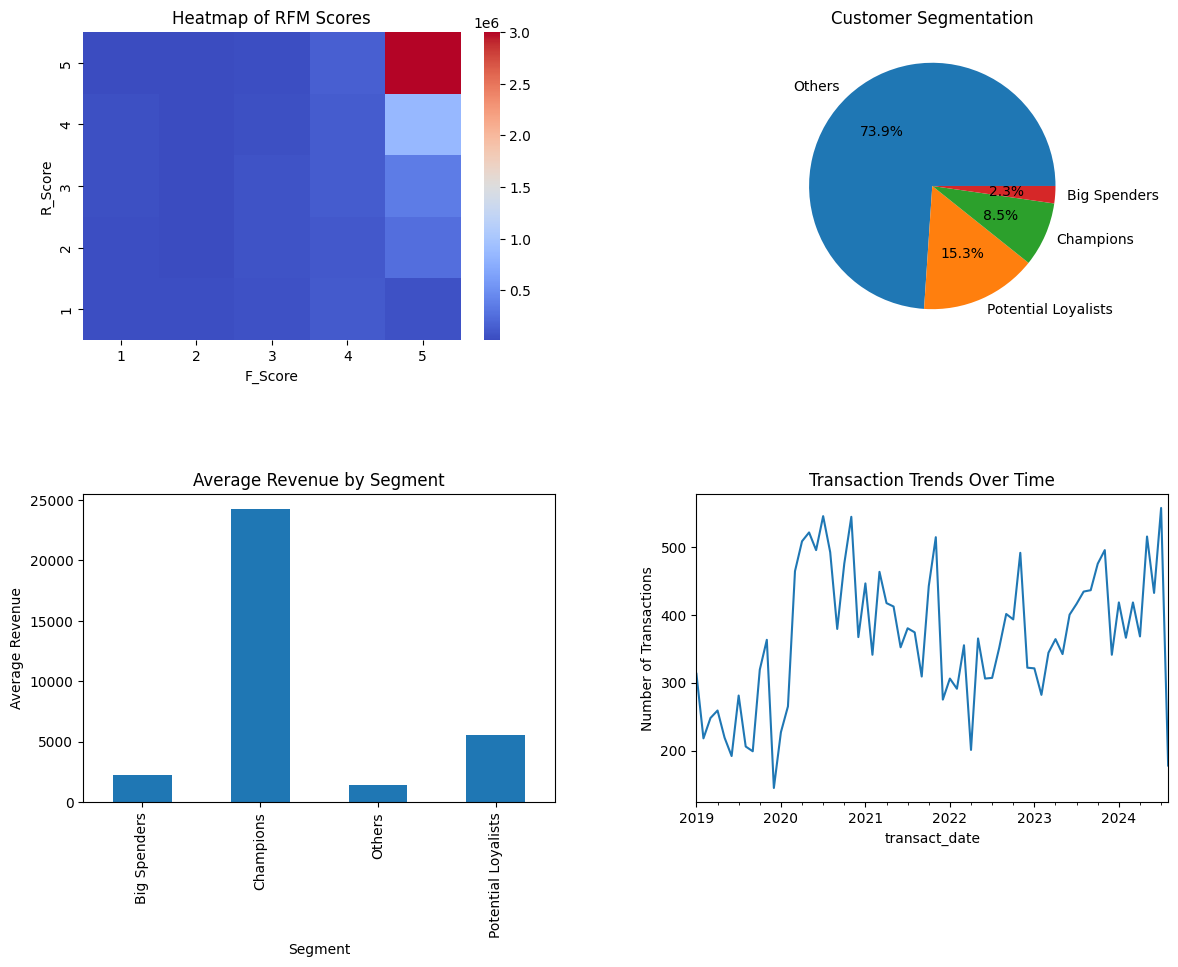

In [15]:

# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Adjust spacing
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# 1. Heatmap of RFM scores
rfm_heatmap = rfm_df.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='sum')
sns.heatmap(rfm_heatmap, cmap='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title('Heatmap of RFM Scores')

# 2. Pie chart of customer segments
rfm_df['Segment'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0, 1])
axes[0, 1].set_title('Customer Segmentation')
axes[0, 1].set_ylabel('')

# 3. Bar chart of average revenue by segment
rfm_df.groupby('Segment')['Monetary'].mean().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Average Revenue by Segment')
axes[1, 0].set_ylabel('Average Revenue')

# 4. Line chart of transaction trends over time
df1.groupby(df1['transact_date'].dt.to_period('M'))['transaction_id'].count().plot(kind='line', ax=axes[1, 1])
axes[1, 1].set_title('Transaction Trends Over Time')
axes[1, 1].set_ylabel('Number of Transactions')

# Display the plots
plt.show()


### Data Comparison Customer Dataset 1 vs. Customer Dataset 2

In [17]:
df1['transact_date'] = pd.to_datetime(df1['transact_date'])
df2['transact_date'] = pd.to_datetime(df2['transact_date'])


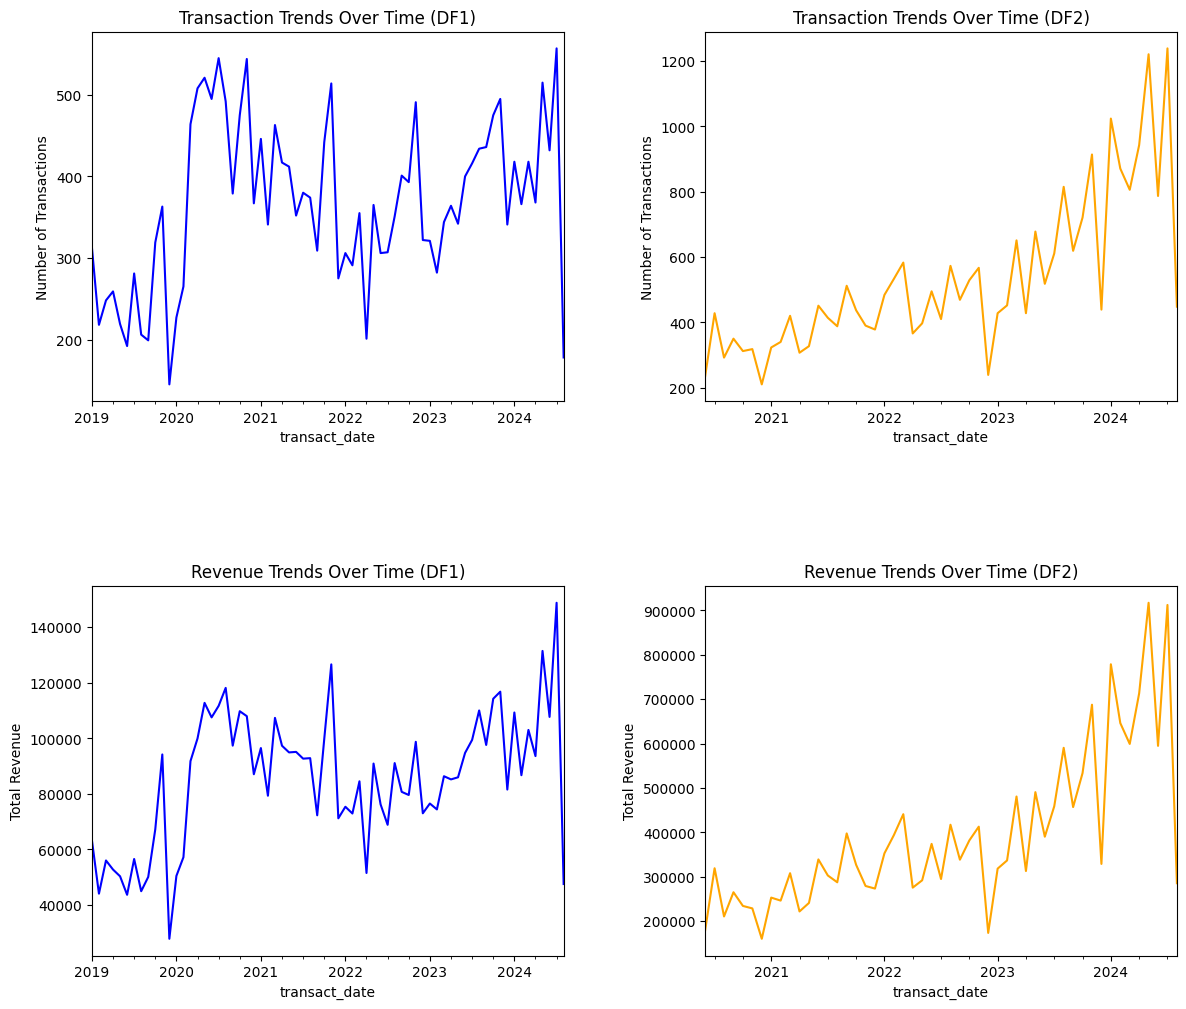

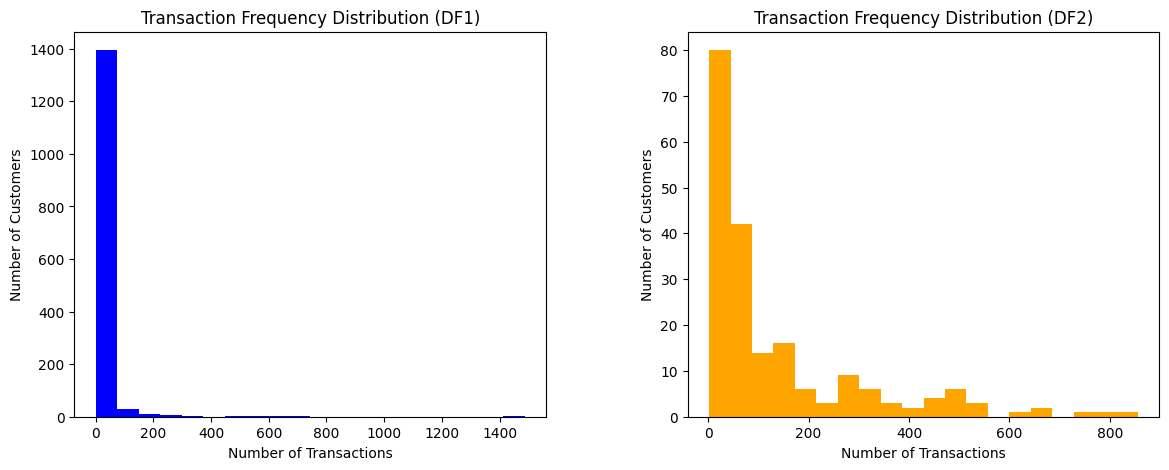

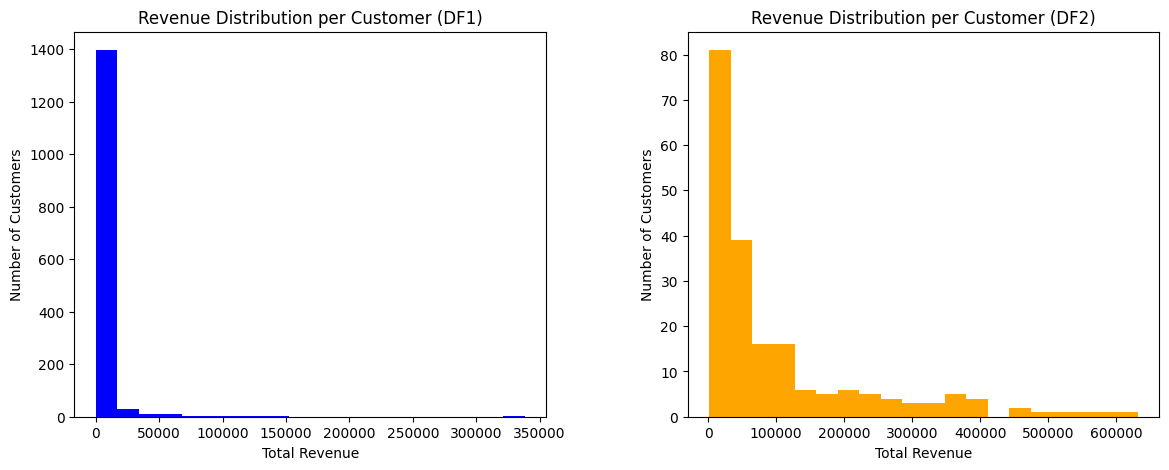

In [18]:
# 1. Transaction Trends Over Time
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

df1.groupby(df1['transact_date'].dt.to_period('M'))['transaction_id'].count().plot(kind='line', ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Transaction Trends Over Time (DF1)')
axes[0, 0].set_ylabel('Number of Transactions')

df2.groupby(df2['transact_date'].dt.to_period('M'))['transaction_id'].count().plot(kind='line', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Transaction Trends Over Time (DF2)')
axes[0, 1].set_ylabel('Number of Transactions')

# 2. Total Revenue Comparison
df1.groupby(df1['transact_date'].dt.to_period('M'))['revenue'].sum().plot(kind='line', ax=axes[1, 0], color='blue')
axes[1, 0].set_title('Revenue Trends Over Time (DF1)')
axes[1, 0].set_ylabel('Total Revenue')

df2.groupby(df2['transact_date'].dt.to_period('M'))['revenue'].sum().plot(kind='line', ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Revenue Trends Over Time (DF2)')
axes[1, 1].set_ylabel('Total Revenue')

plt.show()

# 3. Frequency Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.3)

df1.groupby('customer_id')['transaction_id'].count().plot(kind='hist', ax=axes[0], color='blue', bins=20)
axes[0].set_title('Transaction Frequency Distribution (DF1)')
axes[0].set_xlabel('Number of Transactions')
axes[0].set_ylabel('Number of Customers')

df2.groupby('customer_id')['transaction_id'].count().plot(kind='hist', ax=axes[1], color='orange', bins=20)
axes[1].set_title('Transaction Frequency Distribution (DF2)')
axes[1].set_xlabel('Number of Transactions')
axes[1].set_ylabel('Number of Customers')

plt.show()

# 4. Revenue Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.3)

df1.groupby('customer_id')['revenue'].sum().plot(kind='hist', ax=axes[0], color='blue', bins=20)
axes[0].set_title('Revenue Distribution per Customer (DF1)')
axes[0].set_xlabel('Total Revenue')
axes[0].set_ylabel('Number of Customers')

df2.groupby('customer_id')['revenue'].sum().plot(kind='hist', ax=axes[1], color='orange', bins=20)
axes[1].set_title('Revenue Distribution per Customer (DF2)')
axes[1].set_xlabel('Total Revenue')
axes[1].set_ylabel('Number of Customers')

plt.show()
